In [2]:
import os 
import glob 
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import shutil
from scipy.stats import linregress
import cartopy.io.shapereader as shpreader
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from shapely.prepared import prep
import regionmask
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import xesmf as xe
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
import matplotlib.cm as cm
import calendar
from collections import Counter
import itertools
import rasterio
import struct
from datetime import datetime, timedelta
from tqdm import tqdm
import subprocess
import urllib.request
import zipfile

# Set global font to a sans-serif type suitable for publishing
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use 'Helvetica' or 'DejaVu Sans' if Arial is unavailable
    'font.size': 8,               # Default font size
    'axes.titlesize': 8,          # Title font size
    'axes.labelsize': 8,          # X and Y labels font size
    'xtick.labelsize': 8,         # X-axis tick labels font size
    'ytick.labelsize': 8,         # Y-axis tick labels font size
    'legend.fontsize': 8,         # Legend font size
    'figure.titlesize': 8         # Figure title font size
})

# Change inputs

Files structure is .$home/PRISM/{var_name}/netdf

In [3]:
# home = '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM'
home = '/home/sd96/rdf'
# home = '/home/sd96/wastewater'
# shapefile = os.path.join(home, 'harris_county.geojson')
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
# shapefile = "/home/ib28/mymount/sd75/isabelleb/wastewater/shapefiles/Regional_County_Boundaries.shp"

# Downloading BIL Files from PRISM 

    Saves zip files in rdf in folders `zip_ppt`, `zip_tmean`, `zip_tdmean`
    Saves unziped files in rdf folders `ppt`, `tmean`, `tdmean`

In [24]:
daily = "D2"
monthly = "M3"
clim_var = "tmean"
folder = os.path.join(home, f'zip_{clim_var}')
base_url = "https://services.nacse.org/prism/data/public/4km"
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

In [20]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import urllib.request
import os

def _progress_hook(block_num, block_size, total_size, t):
    """
    Callback function to update tqdm progress bar during file download.
    """
    downloaded = block_num * block_size
    if total_size > 0:
        t.update(min(block_size, total_size - t.n))
    else:
        t.update(downloaded - t.n)

vars = ['tmean', 'tdmean']

for clim_var in vars:
    folder = os.path.join(home, f'zip_{clim_var}')
    print("Downloading files for", clim_var, "in folder", os.path.join(folder))
    print(f"Using url {base_url}/{clim_var}/{month}")
    curr = start
    while curr <= stop:
        month = curr.strftime("%Y%m")
        url = f"{base_url}/{clim_var}/{month}"
        output_file = os.path.join(folder, month)
        
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=f'Downloading {month}') as t:
            urllib.request.urlretrieve(
                url,
                output_file,
                reporthook=lambda block_num, block_size, total_size: _progress_hook(block_num, block_size, total_size, t)
            )

        curr += relativedelta(months=1)

Using url https://services.nacse.org/prism/data/public/4km/tmean/202412


Using url https://services.nacse.org/prism/data/public/4km/tdmean/202412


In [21]:
vars = ['tmean', 'tdmean']
for clim_var in vars:
    
    unzip_folder = os.path.join(home, clim_var)
    print(f"Unzipping {clim_var} files in {unzip_folder}")
    folder = os.path.join(home, f'zip_{clim_var}')
    print("Using folder", folder)
    print(start)
    
    curr = start
    while curr <= stop:
        month = curr.strftime("%Y%m")
        zip_file_path = os.path.join(folder, month)

        # Check if the ZIP file exists
        if os.path.exists(zip_file_path):
            # Unzip the file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(unzip_folder)
                print(f"UNZIP file for {month} is completed.")
        else:
            print(f"ZIP file for {month} not found.")

        curr += relativedelta(months=1)

Unzipping tmean files in /home/sd96/rdf/tmean
Using folder /home/sd96/rdf/zip_tmean
2020-01-01 00:00:00
UNZIP file for 202001 is completed.
UNZIP file for 202002 is completed.
UNZIP file for 202003 is completed.
UNZIP file for 202004 is completed.
UNZIP file for 202005 is completed.
UNZIP file for 202006 is completed.
UNZIP file for 202007 is completed.
UNZIP file for 202008 is completed.
UNZIP file for 202009 is completed.
UNZIP file for 202010 is completed.
UNZIP file for 202011 is completed.
UNZIP file for 202012 is completed.
UNZIP file for 202101 is completed.
UNZIP file for 202102 is completed.
UNZIP file for 202103 is completed.
UNZIP file for 202104 is completed.
UNZIP file for 202105 is completed.
UNZIP file for 202106 is completed.
UNZIP file for 202107 is completed.
UNZIP file for 202108 is completed.
UNZIP file for 202109 is completed.
UNZIP file for 202110 is completed.
UNZIP file for 202111 is completed.
UNZIP file for 202112 is completed.
UNZIP file for 202201 is complet

In [25]:
def parse_header(hdr_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def read_bil_manual(bil_path, hdr_path):
    """
    Reads a .bil file manually using information from its .hdr file.
    """
    header = parse_header(hdr_path)

    nrows = int(header.get('NROWS', 0))
    ncols = int(header.get('NCOLS', 0))
    nbits = int(header.get('NBITS', 0))
    byteorder = header.get('BYTEORDER', 'I') # 'I' for Intel (little-endian), 'M' for Motorola (big-endian)
    pixeltype = header.get('PIXELTYPE', 'SIGNEDINT') # Example: FLOAT, SIGNEDINT, UNSIGNEDINT

    # Determine data type for struct and numpy
    if nbits == 8:
        dtype = np.int8 if pixeltype == 'SIGNEDINT' else np.uint8
        fmt_char = 'b' if pixeltype == 'SIGNEDINT' else 'B'
    elif nbits == 16:
        dtype = np.int16 if pixeltype == 'SIGNEDINT' else np.uint16
        fmt_char = 'h' if pixeltype == 'SIGNEDINT' else 'H'
    elif nbits == 32:
        if pixeltype == 'FLOAT':
            dtype = np.float32
            fmt_char = 'f'
        else:
            dtype = np.int32 if pixeltype == 'SIGNEDINT' else np.uint32
            fmt_char = 'i' if pixeltype == 'SIGNEDINT' else 'I'
    else:
        raise ValueError(f"Unsupported NBITS: {nbits}")

    endian_prefix = '<' if byteorder == 'I' else '>' # Little-endian or Big-endian

    with open(bil_path, 'rb') as f:
        bil_data = f.read()

    # Unpack binary data
    num_elements = nrows * ncols
    format_string = f"{endian_prefix}{num_elements}{fmt_char}"
    unpacked_data = struct.unpack(format_string, bil_data)

    # Reshape into a 2D array
    data_array = np.array(unpacked_data, dtype=dtype).reshape(nrows, ncols)

    return data_array

# Example usage:
bil_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.bil') 
hdr_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.hdr') 
bil_data_manual = read_bil_manual(bil_file, hdr_file)

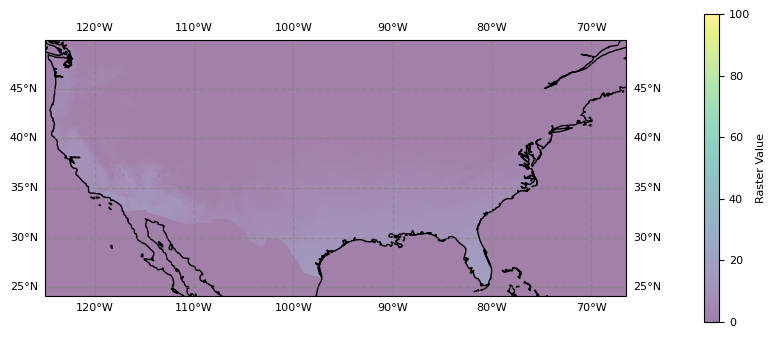

In [28]:
# Read raster data from .bil file
bil_file_path = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{monthly}_202101_bil.bil') 

# Use rasterio to read the raster data
with rasterio.open(bil_file_path) as src:
    raster_data = src.read(1)
    transform = src.transform

# Visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the desired minimum and maximum values for the colormap
vmin = 0  
vmax = 100  

# Plot the raster data using imshow with vmin and vmax
im = ax.imshow(raster_data, extent=(transform[2], transform[2] + transform[0] * raster_data.shape[1],
                                    transform[5] + transform[4] * raster_data.shape[0], transform[5]),
               origin='upper', cmap='viridis', alpha=0.5, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.4)
cbar.set_label('Raster Value')

# Add gridlines and coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.show()

In [30]:
# Convert the data into an xarray dataset 

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

header_data = parse_header(hdr_file)
x0 = float(header_data['ULXMAP'])
y0 = float(header_data['ULYMAP'])
dx = float(header_data['XDIM'])
dy = float(header_data['YDIM'])
    
Nx = raster_data.shape[1]
Ny = raster_data.shape[0]
# dx = transform[0]
# dy = transform[4]
# x0 = transform[2]
# y0 = transform[5] 
    
longitude = create_array_with_step(Nx, x0, dx)
latitude = create_array_with_step(Ny, y0, -dy) 
filename_parts = bil_file_path.split('.')[0].split('_') 

# Daily 
timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 

# Monthly 
# timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
var_data = np.expand_dims(raster_data, axis=2)

In [31]:
ds = xr.Dataset(
    data_vars=dict(
        tmean=(('lat', 'lon', 'time'), var_data),
    ),
    coords=dict(
        lon=('lon', longitude),
        lat=('lat', latitude),
        time=('time', timestamp), 
    ),
    attrs=dict(description="PRISM data"),
)

<GeoAxes: title={'center': 'time = 2021-01-01'}, xlabel='lon', ylabel='lat'>

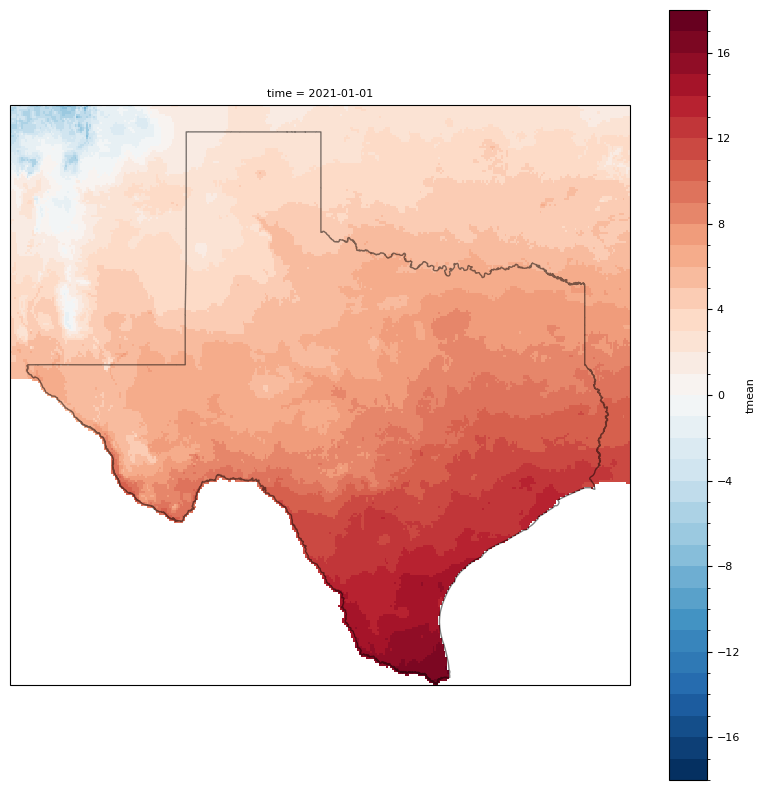

In [35]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-10, 31, 1) 
ds = ds.sortby('lat') 
ds_plot = ds.sel(lat = slice(25, 37), lon = slice(-107, -93)) 
ds_plot = ds_plot.where(ds_plot.tmean > -8000, drop = True) 
levels = np.arange(-18, 19, 1)
ds_plot.sel(time = '20210101').tmean.plot(x = 'lon', y = 'lat', ax = ax, levels = levels)

shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
states = gpd.read_file(shapefile)

##### Filter for Texas #####
texas = states[states['NAME'] == 'Texas']

##### Plot Texas Boundary #####
texas.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=1)

# Read all datasets into NetCDF format

In [37]:
def parse_header(hdr_file_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def parse_bil(bil_file_path): 
    # Use rasterio to read the raster data
    with rasterio.open(bil_file_path) as src:
        raster_data = src.read(1)
    return raster_data       

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

In [38]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for var in variables:
    
    homedir = f'{var}'
    
    outdir = os.path.join(home, homedir, 'netcdf') 
    print(f"Saving files in {outdir}")
    if os.path.exists(outdir) == False: 
        os.mkdir(outdir) 
    for year in years: 
        for m in months: 
            bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.bil') 
            hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.hdr') 
    
            outfile = os.path.join(home, outdir, f'PRISM_{var}_stable_4kmM3_{year}{m}.nc')
    
            # Read in raster data 
            raster_data = parse_bil(bil_file) 
            Nx = raster_data.shape[1]
            Ny = raster_data.shape[0]
    
            # Read in header data 
            hdr_data = parse_header(hdr_file) 
            x0 = float(hdr_data['ULXMAP'])
            y0 = float(hdr_data['ULYMAP'])
            dx = float(hdr_data['XDIM'])
            dy = float(hdr_data['YDIM'])
    
            # Create coordinate arrays for dataset 
            longitude = create_array_with_step(Nx, x0, dx)
            latitude = create_array_with_step(Ny, y0, -dy) 
            filename_parts = bil_file.split('.')[0].split('_') 
            timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
            var_data = np.expand_dims(raster_data, axis=2)
    
            # Create dataset 
            ds = xr.Dataset(
                data_vars=dict(
                    tmp=(('lat', 'lon', 'time'), var_data),
                ),
                coords=dict(
                    lon=('lon', longitude),
                    lat=('lat', latitude),
                    time=('time', timestamp), 
                ),
                attrs=dict(description=f"PRISM {var} data"),
            )
            ds = ds.rename({'tmp':var})
    
            # Save dataset 
            ds.to_netcdf(outfile) 
            print("Saved", outfile)
            ds.close()

Saving files in /home/sd96/rdf/tmean/netcdf
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202101.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202102.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202103.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202104.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202105.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202106.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202107.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202108.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202109.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202110.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202111.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202112.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_202201.nc
Saved /home/sd96/rdf/tmean/netcdf/PRISM_tmean_stable_4kmM3_

In [33]:
##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties_shapefile = gpd.read_file(counties_shapefile_path)

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

# ##### Filter for HC #####
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

print(HC.geometry.bounds)
print(HC.geometry.crs) 

           minx       miny       maxx       maxy
1318 -95.960733  29.497297 -94.908492  30.170606
EPSG:4269


# Get values in Harris County 

In [42]:
##### -------- Get KG Classes for Texas -------- #####

##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
# counties = gpd.read_file(shapefile)
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(counties_shapefile_path)

# ##### Filter for HC #####
# HC = counties[counties.NAME == 'Harris']
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

##### Read in files #####
variables = ['tmean', 'tdmean', 'ppt'] 
for var in variables: 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    
    print(f"sorting file in directory {homedir}")
    
    # Get all the monthly files 
    files = glob.glob(os.path.join(home, homedir, 'PRISM*M3*.nc'))
    files.sort() 

#     for f in files: 
    for f in tqdm(files, desc=f"Processing {var}", unit="file"):

        filename = f.split('/')[-1].split('.')[0]
        print(filename)
        outfile = os.path.join(home, homedir, f'Harris_County_{filename}.nc') 
        
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        with xr.open_dataset(f) as ds: 

            # Limit file 
            ds = ds.sortby('lat') 
            ds = ds.sel(lon = slice(-96.5, -94.5), lat = slice(29.1, 30.5))
            
            # Get the lat/lon coordinates
            lats = ds['lat'].values
            lons = ds['lon'].values
    
            # Create a 2D mesh of coordinates
            lon2d, lat2d = np.meshgrid(lons, lats)
    
            # Flatten the mesh for easier masking
            points = np.array([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())])
    
            # Check which points fall inside the HC polygon
            within_HC = np.array([HC.geometry.iloc[0].contains(p) for p in points])
            mask = within_HC.reshape(lat2d.shape)
    
            # Apply mask to data
            # If 3D (time, lat, lon)
            if "time" in ds.dims:
                mask = np.expand_dims(mask, axis=2)
                masked = ds.where(mask)
            else:
                # 2D (lat, lon)
                masked = ds.where(mask)
            
            # Save data 
            valid_points = masked[var].count().values
            # print(f"\tValid points in {var}: {valid_points}")

            print(f"\tSaved ({valid_points}): {outfile}")
            masked.to_netcdf(outfile) 

sorting file in directory /home/sd96/rdf/tmean/netcdf


Processing tmean:   0%|                                | 0/36 [00:00<?, ?file/s]

PRISM_tmean_stable_4kmM3_202101


Processing tmean:   3%|▋                       | 1/36 [00:00<00:19,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202101.nc
PRISM_tmean_stable_4kmM3_202102


Processing tmean:   6%|█▎                      | 2/36 [00:01<00:19,  1.78file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202102.nc
PRISM_tmean_stable_4kmM3_202103


Processing tmean:   8%|██                      | 3/36 [00:01<00:18,  1.82file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202103.nc
PRISM_tmean_stable_4kmM3_202104


Processing tmean:  11%|██▋                     | 4/36 [00:02<00:17,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202104.nc
PRISM_tmean_stable_4kmM3_202105


Processing tmean:  14%|███▎                    | 5/36 [00:02<00:17,  1.78file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202105.nc
PRISM_tmean_stable_4kmM3_202106


Processing tmean:  17%|████                    | 6/36 [00:03<00:16,  1.80file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202106.nc
PRISM_tmean_stable_4kmM3_202107


Processing tmean:  19%|████▋                   | 7/36 [00:03<00:15,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202107.nc
PRISM_tmean_stable_4kmM3_202108


Processing tmean:  22%|█████▎                  | 8/36 [00:04<00:15,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202108.nc
PRISM_tmean_stable_4kmM3_202109


Processing tmean:  25%|██████                  | 9/36 [00:04<00:14,  1.81file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202109.nc
PRISM_tmean_stable_4kmM3_202110


Processing tmean:  28%|██████▍                | 10/36 [00:05<00:14,  1.79file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202110.nc
PRISM_tmean_stable_4kmM3_202111


Processing tmean:  31%|███████                | 11/36 [00:06<00:14,  1.78file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202111.nc
PRISM_tmean_stable_4kmM3_202112


Processing tmean:  33%|███████▋               | 12/36 [00:06<00:13,  1.75file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202112.nc
PRISM_tmean_stable_4kmM3_202201


Processing tmean:  36%|████████▎              | 13/36 [00:07<00:13,  1.74file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202201.nc
PRISM_tmean_stable_4kmM3_202202


Processing tmean:  39%|████████▉              | 14/36 [00:07<00:12,  1.77file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202202.nc
PRISM_tmean_stable_4kmM3_202203


Processing tmean:  42%|█████████▌             | 15/36 [00:08<00:11,  1.77file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202203.nc
PRISM_tmean_stable_4kmM3_202204


Processing tmean:  44%|██████████▏            | 16/36 [00:08<00:11,  1.79file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202204.nc
PRISM_tmean_stable_4kmM3_202205


Processing tmean:  47%|██████████▊            | 17/36 [00:09<00:10,  1.79file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202205.nc
PRISM_tmean_stable_4kmM3_202206


Processing tmean:  50%|███████████▌           | 18/36 [00:10<00:09,  1.82file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202206.nc
PRISM_tmean_stable_4kmM3_202207


Processing tmean:  53%|████████████▏          | 19/36 [00:10<00:09,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202207.nc
PRISM_tmean_stable_4kmM3_202208


Processing tmean:  56%|████████████▊          | 20/36 [00:11<00:08,  1.80file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202208.nc
PRISM_tmean_stable_4kmM3_202209


Processing tmean:  58%|█████████████▍         | 21/36 [00:11<00:08,  1.78file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202209.nc
PRISM_tmean_stable_4kmM3_202210


Processing tmean:  61%|██████████████         | 22/36 [00:12<00:07,  1.77file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202210.nc
PRISM_tmean_stable_4kmM3_202211


Processing tmean:  64%|██████████████▋        | 23/36 [00:12<00:07,  1.80file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202211.nc
PRISM_tmean_stable_4kmM3_202212


Processing tmean:  67%|███████████████▎       | 24/36 [00:13<00:06,  1.81file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202212.nc
PRISM_tmean_stable_4kmM3_202301


Processing tmean:  69%|███████████████▉       | 25/36 [00:13<00:06,  1.80file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202301.nc
PRISM_tmean_stable_4kmM3_202302


Processing tmean:  72%|████████████████▌      | 26/36 [00:14<00:05,  1.83file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202302.nc
PRISM_tmean_stable_4kmM3_202303


Processing tmean:  75%|█████████████████▎     | 27/36 [00:15<00:04,  1.81file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202303.nc
PRISM_tmean_stable_4kmM3_202304


Processing tmean:  78%|█████████████████▉     | 28/36 [00:15<00:04,  1.74file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202304.nc
PRISM_tmean_stable_4kmM3_202305


Processing tmean:  81%|██████████████████▌    | 29/36 [00:16<00:04,  1.75file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202305.nc
PRISM_tmean_stable_4kmM3_202306


Processing tmean:  83%|███████████████████▏   | 30/36 [00:16<00:03,  1.77file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202306.nc
PRISM_tmean_stable_4kmM3_202307


Processing tmean:  86%|███████████████████▊   | 31/36 [00:17<00:02,  1.77file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202307.nc
PRISM_tmean_stable_4kmM3_202308


Processing tmean:  89%|████████████████████▍  | 32/36 [00:17<00:02,  1.76file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202308.nc
PRISM_tmean_stable_4kmM3_202309


Processing tmean:  92%|█████████████████████  | 33/36 [00:18<00:01,  1.72file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202309.nc
PRISM_tmean_stable_4kmM3_202310


Processing tmean:  94%|█████████████████████▋ | 34/36 [00:19<00:01,  1.72file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202310.nc
PRISM_tmean_stable_4kmM3_202311


Processing tmean:  97%|██████████████████████▎| 35/36 [00:19<00:00,  1.74file/s]

	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202311.nc
PRISM_tmean_stable_4kmM3_202312


Processing tmean: 100%|███████████████████████| 36/36 [00:20<00:00,  1.78file/s]


	Saved (249): /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202312.nc
sorting file in directory /home/sd96/rdf/tdmean/netcdf


Processing tdmean:   0%|                               | 0/36 [00:00<?, ?file/s]

PRISM_tdmean_stable_4kmM3_202101


Processing tdmean:   3%|▋                      | 1/36 [00:00<00:19,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202101.nc
PRISM_tdmean_stable_4kmM3_202102


Processing tdmean:   6%|█▎                     | 2/36 [00:01<00:19,  1.71file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202102.nc
PRISM_tdmean_stable_4kmM3_202103


Processing tdmean:   8%|█▉                     | 3/36 [00:01<00:19,  1.73file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202103.nc
PRISM_tdmean_stable_4kmM3_202104


Processing tdmean:  11%|██▌                    | 4/36 [00:02<00:18,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202104.nc
PRISM_tdmean_stable_4kmM3_202105


Processing tdmean:  14%|███▏                   | 5/36 [00:02<00:17,  1.75file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202105.nc
PRISM_tdmean_stable_4kmM3_202106


Processing tdmean:  17%|███▊                   | 6/36 [00:03<00:17,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202106.nc
PRISM_tdmean_stable_4kmM3_202107


Processing tdmean:  19%|████▍                  | 7/36 [00:03<00:16,  1.78file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202107.nc
PRISM_tdmean_stable_4kmM3_202108


Processing tdmean:  22%|█████                  | 8/36 [00:04<00:15,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202108.nc
PRISM_tdmean_stable_4kmM3_202109


Processing tdmean:  25%|█████▊                 | 9/36 [00:05<00:14,  1.82file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202109.nc
PRISM_tdmean_stable_4kmM3_202110


Processing tdmean:  28%|██████                | 10/36 [00:05<00:14,  1.81file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202110.nc
PRISM_tdmean_stable_4kmM3_202111


Processing tdmean:  31%|██████▋               | 11/36 [00:06<00:13,  1.81file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202111.nc
PRISM_tdmean_stable_4kmM3_202112


Processing tdmean:  33%|███████▎              | 12/36 [00:06<00:13,  1.83file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202112.nc
PRISM_tdmean_stable_4kmM3_202201


Processing tdmean:  36%|███████▉              | 13/36 [00:07<00:12,  1.83file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202201.nc
PRISM_tdmean_stable_4kmM3_202202


Processing tdmean:  39%|████████▌             | 14/36 [00:07<00:11,  1.84file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202202.nc
PRISM_tdmean_stable_4kmM3_202203


Processing tdmean:  42%|█████████▏            | 15/36 [00:08<00:11,  1.78file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202203.nc
PRISM_tdmean_stable_4kmM3_202204


Processing tdmean:  44%|█████████▊            | 16/36 [00:08<00:11,  1.79file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202204.nc
PRISM_tdmean_stable_4kmM3_202205


Processing tdmean:  47%|██████████▍           | 17/36 [00:09<00:10,  1.80file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202205.nc
PRISM_tdmean_stable_4kmM3_202206


Processing tdmean:  50%|███████████           | 18/36 [00:10<00:09,  1.81file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202206.nc
PRISM_tdmean_stable_4kmM3_202207


Processing tdmean:  53%|███████████▌          | 19/36 [00:10<00:09,  1.83file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202207.nc
PRISM_tdmean_stable_4kmM3_202208


Processing tdmean:  56%|████████████▏         | 20/36 [00:11<00:08,  1.84file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202208.nc
PRISM_tdmean_stable_4kmM3_202209


Processing tdmean:  58%|████████████▊         | 21/36 [00:11<00:08,  1.84file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202209.nc
PRISM_tdmean_stable_4kmM3_202210


Processing tdmean:  61%|█████████████▍        | 22/36 [00:12<00:07,  1.83file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202210.nc
PRISM_tdmean_stable_4kmM3_202211


Processing tdmean:  64%|██████████████        | 23/36 [00:12<00:07,  1.84file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202211.nc
PRISM_tdmean_stable_4kmM3_202212


Processing tdmean:  67%|██████████████▋       | 24/36 [00:13<00:06,  1.80file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202212.nc
PRISM_tdmean_stable_4kmM3_202301


Processing tdmean:  69%|███████████████▎      | 25/36 [00:13<00:06,  1.77file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202301.nc
PRISM_tdmean_stable_4kmM3_202302


Processing tdmean:  72%|███████████████▉      | 26/36 [00:14<00:05,  1.77file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202302.nc
PRISM_tdmean_stable_4kmM3_202303


Processing tdmean:  75%|████████████████▌     | 27/36 [00:15<00:05,  1.80file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202303.nc
PRISM_tdmean_stable_4kmM3_202304


Processing tdmean:  78%|█████████████████     | 28/36 [00:15<00:04,  1.61file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202304.nc
PRISM_tdmean_stable_4kmM3_202305


Processing tdmean:  81%|█████████████████▋    | 29/36 [00:16<00:04,  1.67file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202305.nc
PRISM_tdmean_stable_4kmM3_202306


Processing tdmean:  83%|██████████████████▎   | 30/36 [00:16<00:03,  1.71file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202306.nc
PRISM_tdmean_stable_4kmM3_202307


Processing tdmean:  86%|██████████████████▉   | 31/36 [00:17<00:02,  1.74file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202307.nc
PRISM_tdmean_stable_4kmM3_202308


Processing tdmean:  89%|███████████████████▌  | 32/36 [00:17<00:02,  1.75file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202308.nc
PRISM_tdmean_stable_4kmM3_202309


Processing tdmean:  92%|████████████████████▏ | 33/36 [00:18<00:01,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202309.nc
PRISM_tdmean_stable_4kmM3_202310


Processing tdmean:  94%|████████████████████▊ | 34/36 [00:19<00:01,  1.78file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202310.nc
PRISM_tdmean_stable_4kmM3_202311


Processing tdmean:  97%|█████████████████████▍| 35/36 [00:19<00:00,  1.76file/s]

	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202311.nc
PRISM_tdmean_stable_4kmM3_202312


Processing tdmean: 100%|██████████████████████| 36/36 [00:20<00:00,  1.78file/s]


	Saved (249): /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmM3_202312.nc
sorting file in directory /home/sd96/rdf/ppt/netcdf


Processing ppt:   0%|                                  | 0/36 [00:00<?, ?file/s]

PRISM_ppt_stable_4kmM3_202101


Processing ppt:   3%|▋                         | 1/36 [00:00<00:19,  1.79file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202101.nc
PRISM_ppt_stable_4kmM3_202102


Processing ppt:   6%|█▍                        | 2/36 [00:01<00:18,  1.83file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202102.nc
PRISM_ppt_stable_4kmM3_202103


Processing ppt:   8%|██▏                       | 3/36 [00:01<00:18,  1.78file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202103.nc
PRISM_ppt_stable_4kmM3_202104


Processing ppt:  11%|██▉                       | 4/36 [00:02<00:17,  1.81file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202104.nc
PRISM_ppt_stable_4kmM3_202105


Processing ppt:  14%|███▌                      | 5/36 [00:02<00:17,  1.81file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202105.nc
PRISM_ppt_stable_4kmM3_202106


Processing ppt:  17%|████▎                     | 6/36 [00:03<00:16,  1.80file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202106.nc
PRISM_ppt_stable_4kmM3_202107


Processing ppt:  19%|█████                     | 7/36 [00:03<00:15,  1.82file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202107.nc
PRISM_ppt_stable_4kmM3_202108


Processing ppt:  22%|█████▊                    | 8/36 [00:04<00:15,  1.82file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202108.nc
PRISM_ppt_stable_4kmM3_202109


Processing ppt:  25%|██████▌                   | 9/36 [00:04<00:15,  1.79file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202109.nc
PRISM_ppt_stable_4kmM3_202110


Processing ppt:  28%|██████▉                  | 10/36 [00:05<00:15,  1.63file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202110.nc
PRISM_ppt_stable_4kmM3_202111


Processing ppt:  31%|███████▋                 | 11/36 [00:06<00:14,  1.69file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202111.nc
PRISM_ppt_stable_4kmM3_202112


Processing ppt:  33%|████████▎                | 12/36 [00:06<00:14,  1.67file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202112.nc
PRISM_ppt_stable_4kmM3_202201


Processing ppt:  36%|█████████                | 13/36 [00:07<00:13,  1.74file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202201.nc
PRISM_ppt_stable_4kmM3_202202


Processing ppt:  39%|█████████▋               | 14/36 [00:08<00:13,  1.65file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202202.nc
PRISM_ppt_stable_4kmM3_202203


Processing ppt:  42%|██████████▍              | 15/36 [00:08<00:12,  1.65file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202203.nc
PRISM_ppt_stable_4kmM3_202204


Processing ppt:  44%|███████████              | 16/36 [00:09<00:12,  1.61file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202204.nc
PRISM_ppt_stable_4kmM3_202205


Processing ppt:  47%|███████████▊             | 17/36 [00:09<00:11,  1.63file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202205.nc
PRISM_ppt_stable_4kmM3_202206


Processing ppt:  50%|████████████▌            | 18/36 [00:10<00:11,  1.63file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202206.nc
PRISM_ppt_stable_4kmM3_202207


Processing ppt:  53%|█████████████▏           | 19/36 [00:11<00:10,  1.66file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202207.nc
PRISM_ppt_stable_4kmM3_202208


Processing ppt:  56%|█████████████▉           | 20/36 [00:11<00:09,  1.72file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202208.nc
PRISM_ppt_stable_4kmM3_202209


Processing ppt:  58%|██████████████▌          | 21/36 [00:12<00:08,  1.72file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202209.nc
PRISM_ppt_stable_4kmM3_202210


Processing ppt:  61%|███████████████▎         | 22/36 [00:12<00:07,  1.77file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202210.nc
PRISM_ppt_stable_4kmM3_202211


Processing ppt:  64%|███████████████▉         | 23/36 [00:13<00:07,  1.72file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202211.nc
PRISM_ppt_stable_4kmM3_202212


Processing ppt:  67%|████████████████▋        | 24/36 [00:13<00:06,  1.73file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202212.nc
PRISM_ppt_stable_4kmM3_202301


Processing ppt:  69%|█████████████████▎       | 25/36 [00:14<00:06,  1.77file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202301.nc
PRISM_ppt_stable_4kmM3_202302


Processing ppt:  72%|██████████████████       | 26/36 [00:15<00:05,  1.77file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202302.nc
PRISM_ppt_stable_4kmM3_202303


Processing ppt:  75%|██████████████████▊      | 27/36 [00:15<00:05,  1.74file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202303.nc
PRISM_ppt_stable_4kmM3_202304


Processing ppt:  78%|███████████████████▍     | 28/36 [00:16<00:04,  1.75file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202304.nc
PRISM_ppt_stable_4kmM3_202305


Processing ppt:  81%|████████████████████▏    | 29/36 [00:16<00:03,  1.76file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202305.nc
PRISM_ppt_stable_4kmM3_202306


Processing ppt:  83%|████████████████████▊    | 30/36 [00:17<00:03,  1.74file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202306.nc
PRISM_ppt_stable_4kmM3_202307


Processing ppt:  86%|█████████████████████▌   | 31/36 [00:17<00:02,  1.73file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202307.nc
PRISM_ppt_stable_4kmM3_202308


Processing ppt:  89%|██████████████████████▏  | 32/36 [00:18<00:02,  1.68file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202308.nc
PRISM_ppt_stable_4kmM3_202309


Processing ppt:  92%|██████████████████████▉  | 33/36 [00:19<00:01,  1.71file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202309.nc
PRISM_ppt_stable_4kmM3_202310


Processing ppt:  94%|███████████████████████▌ | 34/36 [00:19<00:01,  1.72file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202310.nc
PRISM_ppt_stable_4kmM3_202311


Processing ppt:  97%|████████████████████████▎| 35/36 [00:20<00:00,  1.74file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202311.nc
PRISM_ppt_stable_4kmM3_202312


Processing ppt: 100%|█████████████████████████| 36/36 [00:20<00:00,  1.72file/s]

	Saved (249): /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmM3_202312.nc


infile /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmM3_202101.nc
371


Text(0.5, 0.77, '2021-01 Mean Monthly tmean in Harris County')

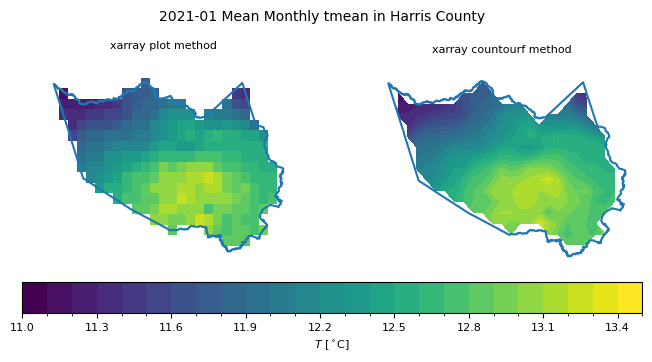

In [49]:
# Plot the Harris County data for 202101 to check 
HC_bounds = [-96.1, -94.8, 29.45, 30.25]

var = 'tmean'
date = '202101'
year = date[:4]
mon = date[4:]
datestr = pd.to_datetime(datestr, format="%Y%m")

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (8, 5))

# ax.set_xlim(HC_bounds[0], HC_bounds[1]) 
# ax.set_ylim(HC_bounds[2], HC_bounds[3]) 

# Plot tmean 
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{monthly}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 
ds = ds.sel(time = datestr, lon = slice(HC_bounds[0], HC_bounds[1]), lat = slice(HC_bounds[2], HC_bounds[3]))
vmin = float(ds[var].min())
vmax = float(ds[var].max())
levels = np.linspace(vmin, vmax, 20)
levels = np.arange(11, 13.6, 0.1) 
# levels = np.arange(11, 13.6, 0.1) 
CS = ds[var].plot(x = 'lon', y = 'lat', ax = ax[0], add_colorbar = False, levels = levels) 
CS = ds[var].plot.contourf(x = 'lon', y = 'lat', ax = ax[1], add_colorbar = False, levels = levels) 
ax[0].set_title('xarray plot method') 
ax[1].set_title('xarray countourf method') 

print(np.isnan(ds[var].values).sum())  # Count NaNs

# Plot HC boundary 
for i in range(2): 
    counties = gpd.read_file(shapefile)
    HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]
    HC.boundary.plot(ax = ax[i]) 
    
    # Plot Characteristics 
    ax[i].axis('off') 
plt.colorbar(CS, ax = ax, orientation = 'horizontal', pad = 0.04, label = r'$T$ [$^\circ$C]') 
plt.suptitle(f'{year}-{mon} Mean Monthly {var} in Harris County', y=0.77, fontsize = 10) 

# Time series of variables averaged over Harris County 

In [8]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [50]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
for var in variables: 
    for year in years: 
        homedir = os.path.join(home, f'{var}', 'netcdf') 
        files = glob.glob(os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}*.nc'))
        files.sort() 
    
        ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').load() 
    
        outfile = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')
           
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        ds.to_netcdf(outfile) 

Text(0, 0.5, 'Precpiptation [mm]')

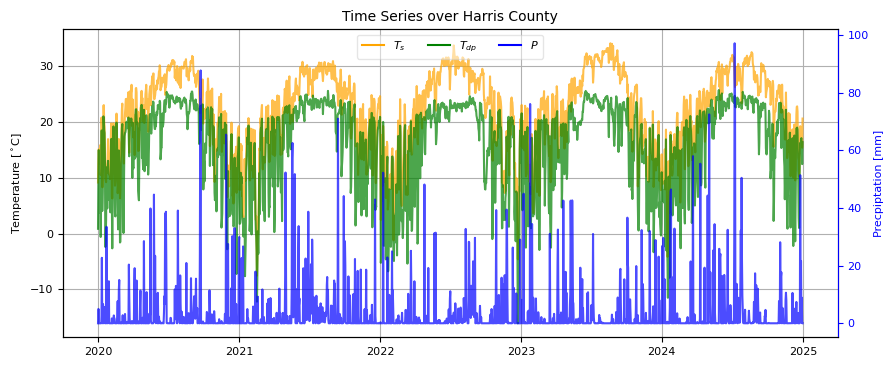

In [18]:
variables = ['tmean', 'tdmean', 'ppt'] 
colors = ['orange', 'green', 'blue'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 

for i, var in enumerate(variables): 
    color = colors[i]
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    
    if var == 'ppt': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(color)
        twin1.tick_params(axis='x', colors=color)
        twin1.tick_params(axis='y', colors=color)
        twin1.set_ylabel('Precpiptation [mm]', color = color) 
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=color, alpha = 0.7) 
#     ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=color, alpha = 0.7) 
        
# Add a legend manually if needed
labels = ['$T_{s}$', r'$T_{dp}$', r'$P$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10) 
twin1.set_ylabel('Precpiptation [mm]', color = color)

# Back Calculate Relative Humidity

In [64]:
def rel_humidity(tas, tdp): 
    ''' 
    Calculates relative humidty (%) using the Mangus approximation 

    Inputs:
    tas - surface temperature (C)
    tdp - dew point temperature (C)

    Outputs:
    hurs - surface relative humidity (%)
    '''
    # Constants
    c1 = 17.625
    c2 = 243.04
    
    print(tdp.shape)
    print(tas.shape)
    # Mangus Forumla
    hurs = 100*(np.exp((c1*tdp)/(c2+tdp))/np.exp((c1*tas)/(c2+tas)))

    return hurs 


def rel_humidity_safe(tas, tdp):
    """
    Calculate relative humidity avoiding coordinate alignment issues
    """
    c1 = 17.625
    c2 = 243.04
    
    print('Input tas shape:', tas.shape)
    print('Input tdp shape:', tdp.shape)
    
    # Work directly with values to avoid coordinate issues
    numerator_vals = np.exp((c1 * tdp.values) / (c2 + tdp.values))
    denominator_vals = np.exp((c1 * tas.values) / (c2 + tas.values))
    
    hurs_vals = 100 * (numerator_vals / denominator_vals)
    
    print('Calculated hurs_vals shape:', hurs_vals.shape)
    
    # Create new DataArray using coordinates from tas (or tdp - they should be the same)
    hurs = xr.DataArray(
        hurs_vals,
        coords={
            'lat': tas.lat,
            'lon': tas.lon, 
            'time': tas.time
        },
        dims=['lat', 'lon', 'time'],
        name='hurs',
        attrs={'units': '%', 'long_name': 'Surface Relative Humidity'}
    )
    
    print('Final hurs shape:', hurs.shape)
    return hurs



In [ ]:
outdir = os.path.join(home, 'netcdf', 'hurs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4kmY2_{year}.nc'))
    files_tmean.sort() 
    files_tdmean = glob.glob(os.path.join(home, 'tdmean', 'netcdf', f'Harris_County_PRISM_tdmean_stable_4kmY2_{year}.nc'))
    files_tdmean.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_tdmean = xr.open_mfdataset(files_tdmean, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(outdir, f'Harris_County_PRISM_hurs_stable_4kmY2_{year}.nc')

    # Calculate relhum: 
    ds_hurs = rel_humidity(ds_tmean.tmean, ds_tdmean.tdmean)

    # Save as netcdf 
    ds_hurs = ds_hurs.to_dataset(name = 'hurs')
    ds_hurs.to_netcdf(outfile)
    

Text(0.5, 1.0, 'Relative Humidity over Harris County')

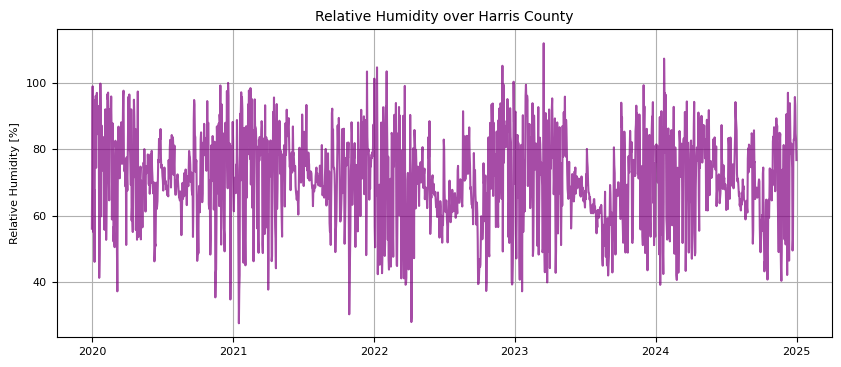

In [17]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
var = 'hurs'

homedir = os.path.join(home, f'{var}', 'netcdf') 
files = []
for year in years: 
    files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')) 

ds = xr.open_mfdataset(files, concat_dim='time', combine='nested', engine='netcdf4')

# ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

# Get mean 
ds_mean = weighted_mean(ds, 'lat', 'lon')

# Plot 
ds_mean[var].plot(x = 'time', ax = ax, color='purple', alpha = 0.7, label = r'$r$') 
# ds_mean[var].plot.scatter(x = 'time', ax = ax, color='purple', alpha = 0.7) 


# ax.legend(loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Relative Humidity [%]') 
ax.grid() 
ax.set_title('Relative Humidity over Harris County', fontsize = 10) 

# Calculate wet bulb temperature 

In [12]:
def stull_wet_bulb_temp(tas, hurs):
    '''
    Calculates the approximation for wet bulb temperature developed by Stull et al (2011)

    Inputs:
    tas - surface temperature (C)
    hurs - relative humidity (%)

    Outputs:
    twbs - wet bulb temperature (C)
    '''

    # Constants
    c1 = 0.151977
    c2 = 8.313659
    c3 = 1.676331
    c4 = 0.00391838
    c5 = 0.023101
    c6 = 4.686035

    # Calculate wet bulb temperature
    twbs = tas * np.arctan(c1 * (hurs + c2)**(0.5)) + np.arctan(tas + hurs) - np.arctan(hurs - c3) + c4 * (hurs)**(1.5) * np.arctan(c5 * hurs) - c6

    return twbs


In [13]:
# outdir = 'twbs'
outdir = os.path.join(home, 'twbs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir)     

print(outdir)

for year in years: 
#     print(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4kmY2_{year}.nc'))
    print("Looking for:", os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4kmY2_{year}.nc'))

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4kmY2_{year}.nc'))
    
    files_tmean.sort() 
    files_hurs = glob.glob(os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4kmY2_{year}.nc'))
    files_hurs.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_hurs = xr.open_mfdataset(files_hurs, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_County_PRISM_twbs_stable_4kmY2_{year}.nc')

    # Calculate relhum: 
    ds_twbs = stull_wet_bulb_temp(ds_tmean.tmean, ds_hurs.hurs)

    # Save as netcdf 
    ds_twbs = ds_twbs.to_dataset(name = 'twbs')
    ds_twbs.to_netcdf(outfile)
    

/home/sd96/rdf/twbs/netcdf
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmY2_2020.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmY2_2021.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmY2_2022.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmY2_2023.nc
Looking for: /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmY2_2024.nc


Text(0.5, 1.0, 'Time Series over Harris County')

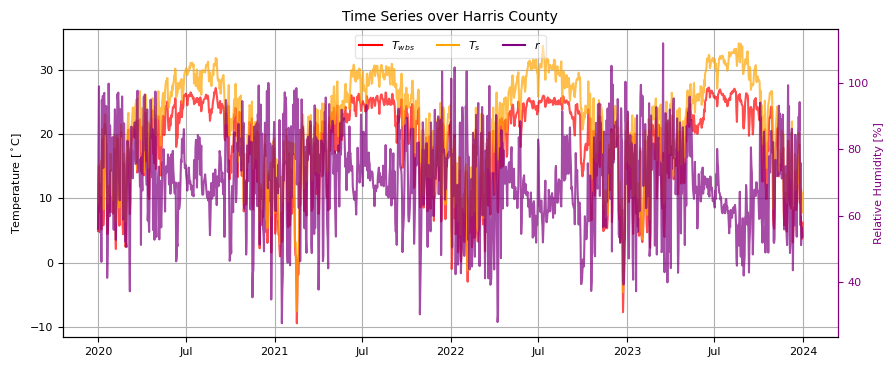

In [15]:
years = ['2020', '2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']

for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")

    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue

    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.7) 
#     ds_mean[var].plot.scatter(x='time', ax=axplot, color=colors[i], alpha=0.7)


labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)


Text(0.5, 1.0, 'Time Series over Harris County')

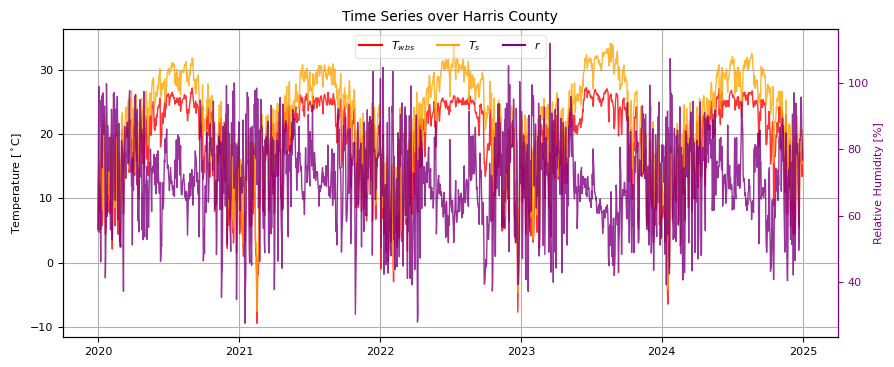

In [16]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax
    # Plot only lines (removed scatter plot)
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.8, linewidth=1)

labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)